
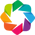

In [87]:
import bokeh
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
from bokeh.io import show
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure, output_file
from bokeh.plotting import figure, save
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, ColorBar, BasicTicker
from bokeh.palettes import RdYlGn10 as palette 
import holoviews as hv
hv.extension('bokeh')

In [88]:
city_geo_price = gpd.read_file('../Data/city_geo_price.shp')
san_jose = gpd.read_file('../Data/sj/tl_2013_06_place.shp')
city_geo_price.at[8, 'geometry'] = san_jose.at[53, 'geometry']

In [89]:
city_geo_price.head()

NAME CityType  Pop2010  Land_sqmi  DateIncorp  \
0        GILROY     City    48821      16.15  1870-03-12   
1   MORGAN HILL     City    37882      12.88  1906-11-10   
2  MONTE SERENO     City     3341       1.62  1957-05-14   
3     LOS GATOS     Town    29413      11.08  1887-08-10   
4      SARATOGA     City    29926      12.38  1956-10-22   

                         WebLink       County      Notes CityAbbv  \
0    http://www.cityofgilroy.org  Santa Clara                 Gil   
1  http://www.morgan-hill.ca.gov  Santa Clara                 MgH   
2     http://www.montesereno.org  Santa Clara                 MSo   
3      http://www.losgatosca.gov  Santa Clara  43-15-008     LGts   
4      http://www.saratoga.ca.us  Santa Clara                 Sar   

    PRICE IN K  $/SQUARE F  PROP COUNT  \
0   646.106441  372.500263         871   
1   755.578266  436.327989         708   
2  2906.868182  906.532286         137   
3  1497.739650  790.309270         734   
4  2050.233454  954.879802         560   

                                            geometry  
0  POLYGON ((-121.5891064263205 37.04772893374334...  
1  POLYGON ((-121.6429347991943 37.16795921325684...  
2  POLYGON ((-121.9772510528564 37.25112342834473...  
3  POLYGON ((-121.9539885568182 37.2122263955635,...  
4  POLYGON ((-122.0027252414766 37.29376939544144...

In [90]:
city_geo_price['PRICE IN K'] = city_geo_price['PRICE IN K'].astype(int)
city_geo_price['$/SQUARE F'] = city_geo_price['$/SQUARE F'].astype(int)

In [91]:
def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return geometry.coords.xy[0]
    elif coord_type == 'y':
        return geometry.coords.xy[1]

def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry.exterior
    return getXYCoords(ext, coord_type)
    
def getLineCoords(geometry, coord_type):
    """ Returns Coordinates of Linestring object."""
    return getXYCoords(geometry, coord_type)

def getPointCoords(geometry, coord_type):
    """ Returns Coordinates of Point object."""
    if coord_type == 'x':
        return geometry.x
    elif coord_type == 'y':
        return geometry.y
    
def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """ 
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon. 
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list. 
    Individual geometries are separated with np.nan which is how Bokeh wants them. 
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """
    
    for i, part in enumerate(multi_geometry):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            if geom_type == "MultiPoint":
                coord_arrays = np.append(getPointCoords(part, coord_type), np.nan)
            elif geom_type == "MultiLineString":
                coord_arrays = np.append(getLineCoords(part, coord_type), np.nan)
            elif geom_type == "MultiPolygon":
                coord_arrays = np.append(getPolyCoords(part, coord_type), np.nan)
        else:
            if geom_type == "MultiPoint":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPointCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiLineString":
                coord_arrays = np.concatenate([coord_arrays, np.append(getLineCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiPolygon":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPolyCoords(part, coord_type), np.nan)])
    
    # Return the coordinates 
    return coord_arrays
    

def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) as a list (if geometry is LineString or Polygon). 
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]
    
    # Check the geometry type
    gtype = geom.geom_type
    
    # "Normal" geometries
    # -------------------
    
    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "LineString":
        return list( getLineCoords(geom, coord_type) )
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )
        
    # Multi geometries
    # ----------------
    
    else:
        return list( multiGeomHandler(geom, coord_type, gtype) ) 
       

In [92]:
city_geo_price['x'] = city_geo_price.apply(getCoords, geom_col="geometry", coord_type="x", axis=1)
city_geo_price['y'] = city_geo_price.apply(getCoords, geom_col="geometry", coord_type="y", axis=1)
city_geo_price['x'] = [np.asarray(i) for i in city_geo_price['x']]
city_geo_price['y'] = [np.asarray(i) for i in city_geo_price['y']]
# city_geo_price.fillna('')

In [93]:
palette.reverse()

color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    xs=city_geo_price['x'],
    ys=city_geo_price['y'],
    name=city_geo_price['NAME'],
    price=city_geo_price['PRICE IN K'],
    unit_price = city_geo_price['$/SQUARE F'],
    number_of_properties = city_geo_price['PROP COUNT']
))


TOOLS = "pan,wheel_zoom,reset,hover,save"

p1 = figure(
    title="Bay Area House Price Choropleth Map", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p1.grid.grid_line_color = None

color_mapper = LogColorMapper(palette=palette, low=city_geo_price['PRICE IN K'].min(), 
                              high=city_geo_price['PRICE IN K'].max())

p1.patches(xs="xs", ys="ys", source=source,
          fill_color={'field': 'price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0), ticker=BasicTicker())
p1.add_layout(color_bar, 'right')

hover = p1.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("City", "@name"),
    ("PRICE IN K", "@price"),
    ("Dollar per sqft", "@unit_price"),
    ("Number of properties", "@number_of_properties")
]


In [94]:
palette.reverse()

color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    xs=city_geo_price['x'],
    ys=city_geo_price['y'],
    name=city_geo_price['NAME'],
    price=city_geo_price['PRICE IN K'],
    unit_price = city_geo_price['$/SQUARE F'],
    number_of_properties = city_geo_price['PROP COUNT']
))


TOOLS = "pan,wheel_zoom,reset,hover,save"

p2 = figure(
    title="Bay Area House Price Choropleth Map", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p2.grid.grid_line_color = None

color_mapper = LogColorMapper(palette=palette, low=city_geo_price['$/SQUARE F'].min(), 
                              high=city_geo_price['$/SQUARE F'].max())

p2.patches(xs="xs", ys="ys", source=source,
          fill_color={'field': 'unit_price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0), ticker=BasicTicker())
p2.add_layout(color_bar, 'right')

hover = p2.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("City", "@name"),
    ("PRICE IN K", "@price"),
    ("Dollar per sqft", "@unit_price"),
    ("Number of properties", "@number_of_properties")
]


In [95]:
tab1 = Panel(child=p1, title='Average House Price')

# Create tab2 from plot p2: tab2
tab2 = Panel(child=p2, title='Average Dollar per sqft')

# Create a Tabs layout: layout
layout = Tabs(tabs=[tab1, tab2])

show(layout)

In [96]:
filename = '../Data/cleaned_data.csv'
df = pd.read_csv(filename)

df_na = df.replace('', np.nan)
df1 = df_na.dropna(subset = ['PROPERTY TYPE', 'PRICE IN K', 'CITY']) 
city = df1['CITY'].unique().tolist()
city.sort()
property_type = df1['PROPERTY TYPE'].unique().tolist()
property_type.sort()
city_type = df1.groupby(['CITY', 'PROPERTY TYPE'])['PRICE IN K'].agg(['mean', 'count'])
city_type = city_type.reset_index()
condo = city_type.loc[city_type['PROPERTY TYPE']== 'Condo']
sfh = city_type.loc[city_type['PROPERTY TYPE']== 'SFH']
th = city_type.loc[city_type['PROPERTY TYPE']== 'TH']

condo.columns = ['NAME', 'PROPERTY TYPE', 'CONDO PRICE IN K', 'NUMBER OF CONDOS']
sfh.columns = ['NAME', 'PROPERTY TYPE', 'SFH PRICE IN K', 'NUMBER OF SFH']
th.columns = ['NAME', 'PROPERTY TYPE', 'TH PRICE IN K', 'NUMBER OF TH']

condo_geo = pd.merge(city_geo_price, condo, on='NAME')
sfh_geo = pd.merge(city_geo_price, sfh, on='NAME')
th_geo = pd.merge(city_geo_price, th, on='NAME')

condo_geo['CONDO PRICE IN K'] = condo_geo['CONDO PRICE IN K'].astype(int)
sfh_geo['SFH PRICE IN K'] = sfh_geo['SFH PRICE IN K'].astype(int)
th_geo['TH PRICE IN K'] = th_geo['TH PRICE IN K'].astype(int)

In [97]:
palette.reverse()

color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    xs=condo_geo['x'],
    ys=condo_geo['y'],
    name=condo_geo['NAME'],
    price=condo_geo['CONDO PRICE IN K'],
    count=condo_geo['NUMBER OF CONDOS']
))


TOOLS = "pan,wheel_zoom,reset,hover,save"

p1 = figure(
    title="Bay Area Condo Price Choropleth Map", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p1.grid.grid_line_color = None
p1.title.align = "center"

color_mapper = LogColorMapper(palette=palette, low=condo_geo['CONDO PRICE IN K'].min(), 
                              high=condo_geo['CONDO PRICE IN K'].max())

p1.patches(xs="xs", ys="ys", source=source,
          fill_color={'field': 'price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0), ticker=BasicTicker())
p1.add_layout(color_bar, 'right')

hover = p1.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("City", "@name"),
    ("PRICE IN K", "@price"),
    ("NUMBER OF CONDOS", "@count")
]


In [98]:
palette.reverse()

color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    xs=sfh_geo['x'],
    ys=sfh_geo['y'],
    name=sfh_geo['NAME'],
    price=sfh_geo['SFH PRICE IN K'],
    count=sfh_geo['NUMBER OF SFH']
))


TOOLS = "pan,wheel_zoom,reset,hover,save"

p2 = figure(
    title="Bay Area Single Family House Price Choropleth Map", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p2.grid.grid_line_color = None
p2.title.align = "center"

color_mapper = LogColorMapper(palette=palette, low=sfh_geo['SFH PRICE IN K'].min(), 
                              high=sfh_geo['SFH PRICE IN K'].max())

p2.patches(xs="xs", ys="ys", source=source,
          fill_color={'field': 'price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0), ticker=BasicTicker())
p2.add_layout(color_bar, 'right')

hover = p2.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("City", "@name"),
    ("PRICE IN K", "@price"),
    ("NUMBER OF SFH", "@count")
]


In [99]:
palette.reverse()

color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    xs=th_geo['x'],
    ys=th_geo['y'],
    name=th_geo['NAME'],
    price=th_geo['TH PRICE IN K'],
    count=th_geo['NUMBER OF TH']
))


TOOLS = "pan,wheel_zoom,reset,hover,save"

p3 = figure(
    title="Bay Area Townhouse Price Choropleth Map", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p3.title.align = "center"
p3.grid.grid_line_color = None

color_mapper = LogColorMapper(palette=palette, low=th_geo['TH PRICE IN K'].min(), 
                              high=th_geo['TH PRICE IN K'].max())

p3.patches(xs="xs", ys="ys", source=source,
          fill_color={'field': 'price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0, 0), ticker=BasicTicker())
p3.add_layout(color_bar, 'right')

hover = p3.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("City", "@name"),
    ("PRICE IN K", "@price"),
    ("NUMBER OF TH", "@count")
]


In [100]:
tab1 = Panel(child=p1, title='Condo')

# Create tab2 from plot p2: tab2
tab2 = Panel(child=p2, title='Single Family House')

# Create tab3 from plot p3: tab3
tab3 = Panel(child=p3, title='Townhouse')

# Create a Tabs layout: layout
layout = Tabs(tabs=[tab1, tab2, tab3])

show(layout)